In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics,cluster 
from umap import UMAP
import multiscale_phate as mp

import scanpy as sc
import scprep

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [19]:
adata = sc.read_h5ad('Tosches_lizard.h5ad')
adata

AnnData object with n_obs × n_vars = 4187 × 15345
    obs: 'region', 'donor', 'cell_type1', 'gender', 'organism', 'dataset_name', 'platform', 'organ', 'data_type', 'cell_ontology_class', 'cell_ontology_id', 'n_genes', 'n_counts', '__libsize__'
    var: 'variable_genes'
    uns: 'author_genes', 'cell_ontology_class_colors', 'cell_type1_colors', 'data_quality', 'donor_colors', 'gender_colors', 'neighbors', 'region_colors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'

In [9]:
data_group = adata.obs['cell_ontology_class']
n_groups = 9
set(data_group)

{'GABAergic inhibitory interneuron',
 'endothelial cell of vascular tree',
 'ependymoglial cell',
 'glutamatergic neuron',
 'leukocyte',
 'microglial cell',
 'nan',
 'oligodendrocyte',
 'oligodendrocyte precursor cell'}

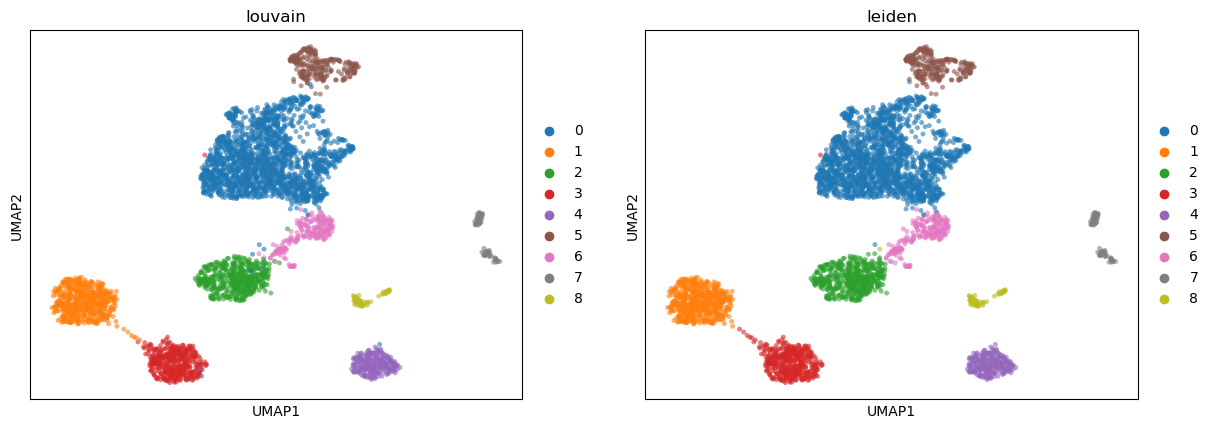

leiden: 0.9276696475465893 0.8767903038922141
louvain: 0.9292170496214752 0.8776874733775036


In [20]:
# sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.2, use_weights=True)
sc.tl.louvain(adata,resolution=0.2, use_weights=True)
sc.pl.umap(adata, color=['louvain', 'leiden'], s=50, alpha=0.6, ncols=2)

leiden_group = np.array(adata.obs['leiden'].values).astype('int')
ari_leiden = metrics.adjusted_rand_score(leiden_group, data_group)
ami_leiden = metrics.adjusted_mutual_info_score(leiden_group, data_group)

louvain_group = np.array(adata.obs['louvain'].values).astype('int')
ari_louvain = metrics.adjusted_rand_score(louvain_group, data_group)
ami_louvain = metrics.adjusted_mutual_info_score(louvain_group, data_group)

print("leiden:",ari_leiden,ami_leiden)
print("louvain:",ari_louvain,ami_louvain)

In [12]:
from dtne import *

In [13]:
X = adata.obsm['latent']

In [21]:
embedding = DTNE(k_neighbors = 30) 
Y = embedding.fit_transform(X)
dtne_cluster = embedding.cluster_cells(n_clusters=n_groups)

ari_dtne = metrics.adjusted_rand_score(dtne_cluster, data_group)
ami_dtne = metrics.adjusted_mutual_info_score(dtne_cluster, data_group)
print("dtne:",ari_dtne,ami_dtne)

dtne: 0.9298790214919049 0.878728955071144


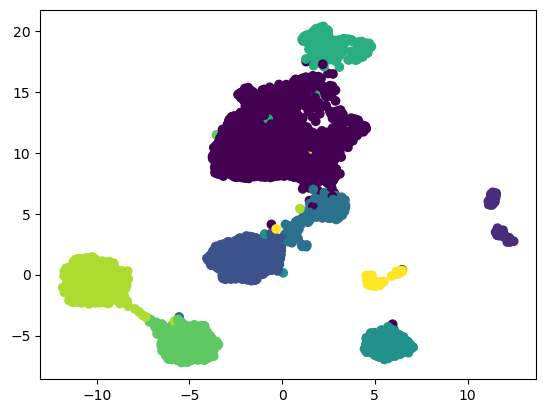

In [22]:
plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c=dtne_cluster)

In [23]:
agglo_instance = cluster.AgglomerativeClustering(n_clusters=n_groups).fit(X)
agglo_groups = agglo_instance.labels_
ari_agglo = metrics.adjusted_rand_score(agglo_groups, data_group)
ami_agglo = metrics.adjusted_mutual_info_score(agglo_groups, data_group)

print("hierarchical:",ari_agglo,ami_agglo)

hierarchical: 0.78341866822727 0.8096064367245454


In [24]:
mp_op = mp.Multiscale_PHATE(random_state=0)
levels = mp_op.fit(X)
levels

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculating diffusion potential...
  Calculated diffusion potential in 5.59 seconds.
  Setting epsilon to 1.7347
  Setting merge threshold to 0.3827
  Calculating condensation...
  Calculated condensation in 7.53 seconds.
Calculated Multiscale PHATE tree in 13.29 seconds.
Computing gradient...
Identifying salient levels of resolution...


[0, 5, 7, 77, 99, 101, 104, 107, 129, 137, 139, 143, 158, 169, 179]

In [28]:
mp_embedding, mp_clusters, mp_sizes = mp_op.transform(visualization_level = 0,cluster_level = 143)
set(mp_clusters)

{0, 131, 400, 437, 509, 789, 1735, 2014, 3234, 3580, 3630}

In [29]:
ari_mp = metrics.adjusted_rand_score(mp_clusters, data_group)
ami_mp = metrics.adjusted_mutual_info_score(mp_clusters, data_group)
print("Multiscale PHATE:",ari_mp,ami_mp)

Multiscale PHATE: 0.8641696239250152 0.8346960718482137


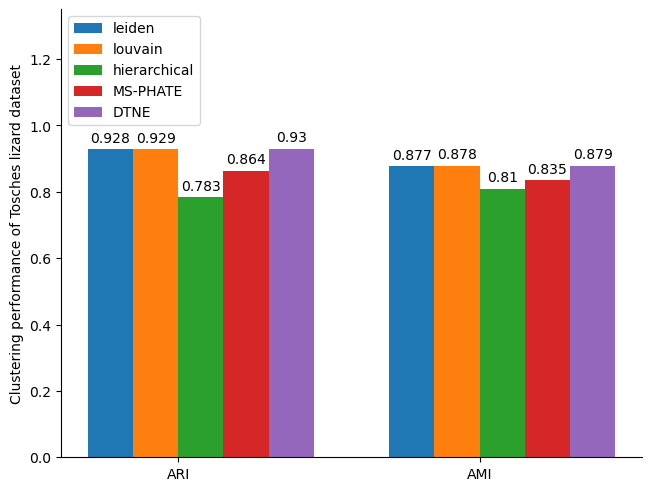

In [31]:
correlation = ['ARI','AMI']
pseudotime_corr = {
    'leiden':(0.928, 0.877),
    'louvain':(0.929, 0.878),
    'hierarchical':(0.783, 0.810),
    'MS-PHATE':(0.864, 0.835),
    'DTNE':(0.930, 0.879)
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, corr, width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Clustering performance of Tosches lizard dataset')
ax.set_xticks(x + 1.5*width, correlation)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 1.35)

sns.despine(top=True,right=True,left=False,bottom=False,)
# ax.grid(False)
# ax.tick_params(bottom=True, left=True)

plt.savefig('./Tosches_lizard_plot.png', format='png', dpi=1000)
plt.savefig('./Tosches_lizard_plot.pdf', format='pdf', dpi=1000)